## Notebook for transferring labels from Kong-2023 stem cells to predicted stem cells using `scarches`

- **Developed by**: Anna Maguza
- **Institute of Computational Biology - Computational Health Centre - Helmholtz Munich**
- v230419

### Load required modules

In [88]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown

In [89]:
import pandas as pd
import anndata as an

In [90]:
import os
os.chdir('../')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [91]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [92]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

### Read in datasets

In [93]:
# Read reference (Kong-2023 dataset)
input_Kong = '/Users/anna.maguza/Desktop/Data/Gut_project/Healthy_gut_data/Kong_2023/Raw_anndata/Kong_2023_raw_anndata.h5ad'
output_Kong = '/Users/anna.maguza/Desktop/Data/Gut_project/Healthy_gut_data/Kong_2023/Processed_anndata/Kong_2023_raw_anndata_output.h5ad'
reference = sc.read(input_Kong)

In [94]:
# Read query (predicted Stem cells)
input_Stem = '/Users/anna.maguza/Desktop/Data/Processed_datasets/Predicted_stem_cells/Predicted_stem_cells.h5ad'
output_Stem = '/Users/anna.maguza/Desktop/Data/Processed_datasets/Predicted_stem_cells/Predicted_stem_cells_output.h5ad'
query = sc.read(input_Stem)

### Preprocess datasets

In [95]:
X_is_raw(query)

True

In [96]:
X_is_raw(reference)

True

In [97]:
# Filter out only healthy samples
reference = reference[reference.obs['disease__ontology_label'] == 'normal']

In [98]:
# Copy gene_id column in query.var as a first column in query.var with a name 'gene_name'
query.var.insert(0, 'gene_name', query.var.index)
# Make a gene name as index
query.var.index = query.var['gene_name']
# Delete gene_name column
del query.var['gene_name']

In [99]:
# Filter cells that have 'Stem cells' in reference.obs['Celltype']
stem_cells_list = ['Stem cells OLFM4 LGR5', 'Stem cells OLFM4 PCNA', 'Stem cells OLFM4 GSTA1', 'Stem cells OLFM4']
reference = reference[reference.obs['Celltype'].isin(stem_cells_list)]

In [100]:
# Rename 'donor_id' column in reference.obs to 'Donor_ID'
reference.obs.rename(columns = {'donor_id': 'Donor_ID'}, inplace = True)
reference.obs['Study_name'] = 'Kong 2023'
reference.obs.rename(columns = {'biosample_id': 'Sample_ID'}, inplace = True)
reference.obs.rename(columns = {'tissue': 'Location'}, inplace = True)
#reference.obs.rename(columns = {'cell_type': 'Celltype'}, inplace = True)
query.obs.rename(columns = {'10X': 'library_preparation_protocol__ontology_label'}, inplace = True)

In [101]:
# Make gene_id as a first column in adata.var
reference.var.insert(0, 'gene_id', reference.var.index)
# Make a gene name as index 
reference.var.index = reference.var['gene_name']

reference.obs_names_make_unique()
query.obs_names_make_unique()
reference.var_names_make_unique()
query.var_names_make_unique()

In [102]:
# Concatenate reference and query
adata = reference.concatenate(query, batch_key = 'dataset', batch_categories = ['reference', 'query'])

In [103]:
X_is_raw(adata)

True

In [104]:
del reference, query

### Select Highly Variable Genes

In [105]:
adata.layers['counts'] = adata.X.copy()

In [106]:
adata.obs['library_preparation_protocol__ontology_label'].value_counts()

library_preparation_protocol__ontology_label
3'           9562
10x 3' v2    8382
10x 3' v1    4757
10x 3' v3    3221
5'           2909
nan          2467
Name: count, dtype: int64

In [107]:
sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 7000,
    layer = "counts",
    batch_key = "library_preparation_protocol__ontology_label",
    subset = True,
    span = 1
)

### Set relevant anndata.obs labels

In [108]:
condition_key = 'dataset'
cell_type_key = 'Celltype'
target_conditions = ['query']

In [109]:
adata = remove_sparsity(adata)
source_adata = adata[~adata.obs[condition_key].isin(target_conditions)].copy()
target_adata = adata[adata.obs[condition_key].isin(target_conditions)].copy()

In [110]:
sca.models.SCVI.setup_anndata(source_adata, batch_key= "Sample_ID", labels_key='Celltype')

In [111]:
vae = sca.models.SCVI(
    source_adata,
    n_layers=2,
    encode_covariates=True,
    deeply_inject_covariates=False,
    use_layer_norm="both",
    use_batch_norm="none",
)

In [112]:
vae.train()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|██████████| 400/400 [39:38<00:00,  5.86s/it, loss=1.62e+03, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [39:38<00:00,  5.95s/it, loss=1.62e+03, v_num=1]


In [113]:
scanvae = sca.models.SCANVI.from_scvi_model(vae, unlabeled_category = "Unknown")

In [114]:
print("Labelled Indices: ", len(scanvae._labeled_indices))
print("Unlabelled Indices: ", len(scanvae._unlabeled_indices))

Labelled Indices:  16360
Unlabelled Indices:  0


In [115]:
scanvae.train(max_epochs=20)

INFO     Training for 20 epochs.                                                                                   


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Epoch 20/20: 100%|██████████| 20/20 [02:18<00:00,  6.96s/it, loss=1.58e+03, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [02:18<00:00,  6.92s/it, loss=1.58e+03, v_num=1]


In [116]:
#ref_path = '/Users/anna.maguza/Downloads/'
#scanvae.save(ref_path, overwrite=False)
#scanvae = torch.load('/Users/anna.maguza/Downloads/model.pt')

### Create anndata file of latent representation

In [117]:
source_adata.obsm["sca_SCANVI"] = scanvae.get_latent_representation()

In [118]:
source_adata.obs['predictions'] = scanvae.predict()

In [119]:
print("Acc: {}".format(np.mean(source_adata.obs.predictions == source_adata.obs.Celltype)))

Acc: 0.9346577017114914


### Perform surgery on reference model and train on query dataset without cell type labels

In [120]:
# Set a new category 'Unknown' for cells that have nan in query.obs['Celltype']
target_adata.obs['Celltype'] = target_adata.obs['Celltype'].cat.add_categories('Unknown')

# Replace nan in query.obs['Celltype'] with 'Unknown'
target_adata.obs['Celltype'].fillna('Unknown', inplace=True)

In [121]:
model = sca.models.SCANVI.load_query_data(
    target_adata,
    scanvae,
    freeze_dropout = True,
)
model._unlabeled_indices = np.arange(target_adata.n_obs)
model._labeled_indices = []
print("Labelled Indices: ", len(model._labeled_indices))
print("Unlabelled Indices: ", len(model._unlabeled_indices))

Labelled Indices:  0
Unlabelled Indices:  14938


In [122]:
model.train(
    max_epochs=100,
    plan_kwargs=dict(weight_decay=0.0),
    check_val_every_n_epoch=10,
)

INFO     Training for 100 epochs.                                                                                  


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Epoch 100/100: 100%|██████████| 100/100 [07:54<00:00,  4.83s/it, loss=2.16e+03, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [07:54<00:00,  4.75s/it, loss=2.16e+03, v_num=1]


In [123]:
target_adata.obsm["sca_SCANVI"] = model.get_latent_representation()

In [124]:
target_adata.obs['predictions'] = model.predict()

### Get latent representation of reference + query dataset and compute UMAP

In [125]:
adata_full = source_adata.concatenate(target_adata)

In [126]:
# Save the output
adata_full.write('/Users/anna.maguza/Desktop/Data/Processed_datasets/Stem_cells_diversity/scarches/stem_cells_diversity_7K_Sample_batch.h5ad')

### Results Validation

In [149]:
# Read the output
input_path = '/Users/anna.maguza/Desktop/Data/Processed_datasets/Stem_cells_diversity/scarches/stem_cells_diversity_5K_Sample_batch.h5ad'
adata_full = sc.read(input_path)

In [150]:
sc.pp.neighbors(adata_full, n_neighbors = 50, metric = 'minkowski')
sc.tl.umap(adata_full, min_dist = 0.2, spread = 2, random_state = 1712)

         Falling back to preprocessing with `sc.pp.pca` and default params.


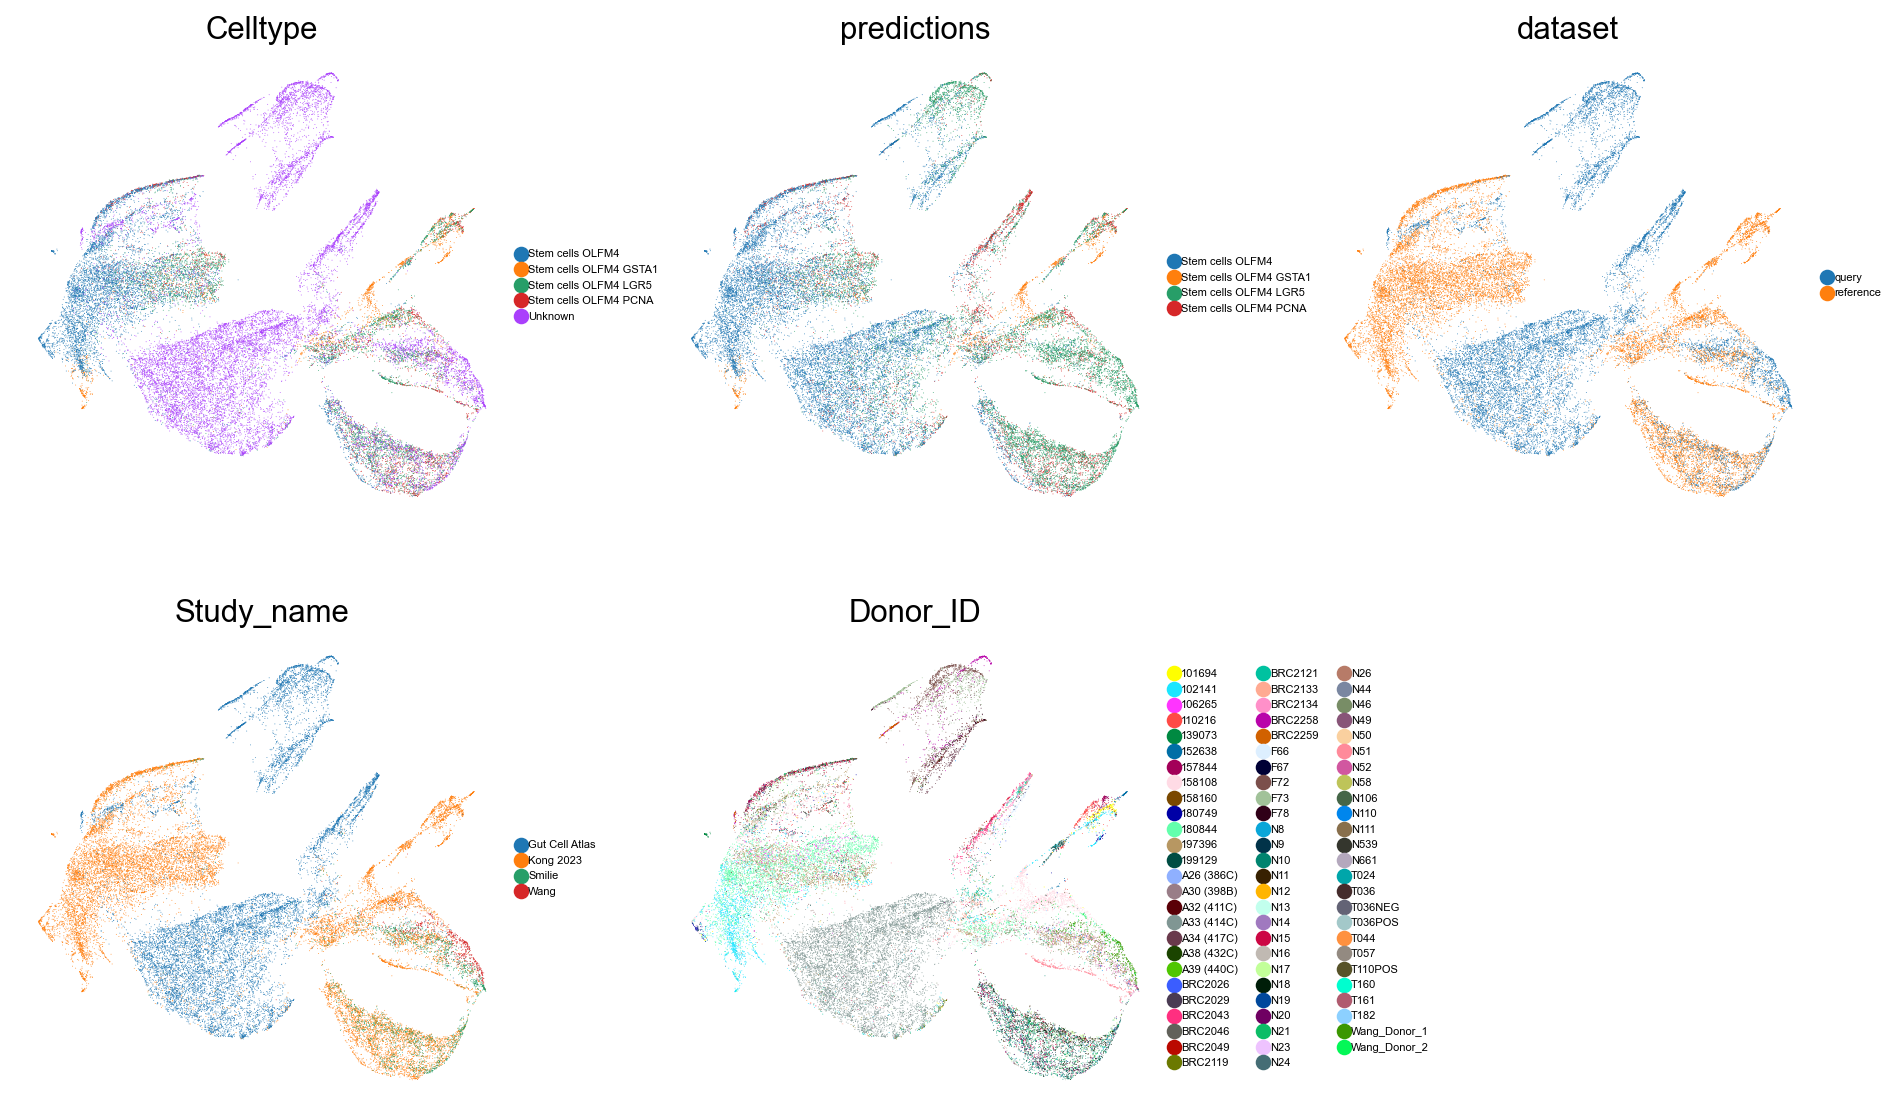

In [151]:
sc.pl.umap(adata_full, frameon = False, color = ['Celltype', 'predictions', 'dataset', 'Study_name', 'Donor_ID'], size = 0.6, legend_fontsize = 5, ncols = 3)

In [156]:
sc.pp.calculate_qc_metrics(adata_full, inplace = True)

In [157]:

del adata_full.obs['pct_counts_in_top_50_genes'], adata_full.obs['pct_counts_in_top_500_genes'], adata_full.obs['pct_counts_in_top_200_genes'], adata_full.obs['pct_counts_in_top_100_genes'], adata_full.obs['log1p_total_counts'], adata_full.obs['log1p_n_genes_by_counts']

In [158]:
adata_full.obs_keys

<bound method AnnData.obs_keys of AnnData object with n_obs × n_vars = 31298 × 5000
    obs: 'cell_type', 'Location', 'batch', 'Sample_ID', 'n_genes', 'n_counts', 'Chem', 'Site', 'Type', 'Donor_ID', 'Layer', 'Celltype', 'sex', 'species', 'species__ontology_label', 'library_preparation_protocol', 'library_preparation_protocol__ontology_label', 'organ', 'organ__ontology_label', 'disease', 'disease__ontology_label', 'Study_name', 'UniqueCell_ID', 'CellType', 'Diagnosis', 'Age', 'Region code', 'Fraction', 'Gender', 'n_genes_by_counts', 'total_counts_mt', 'doublet_scores', 'predicted_doublets', 'Age_group', 'total_counts_ribo', 'percent_mito', 'percent_ribo', 'Cell States', 'Cell Label', 'dataset', '_scvi_batch', '_scvi_labels', 'predictions', 'total_counts'
    var: 'gene_id-reference', 'gene_name-reference', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by

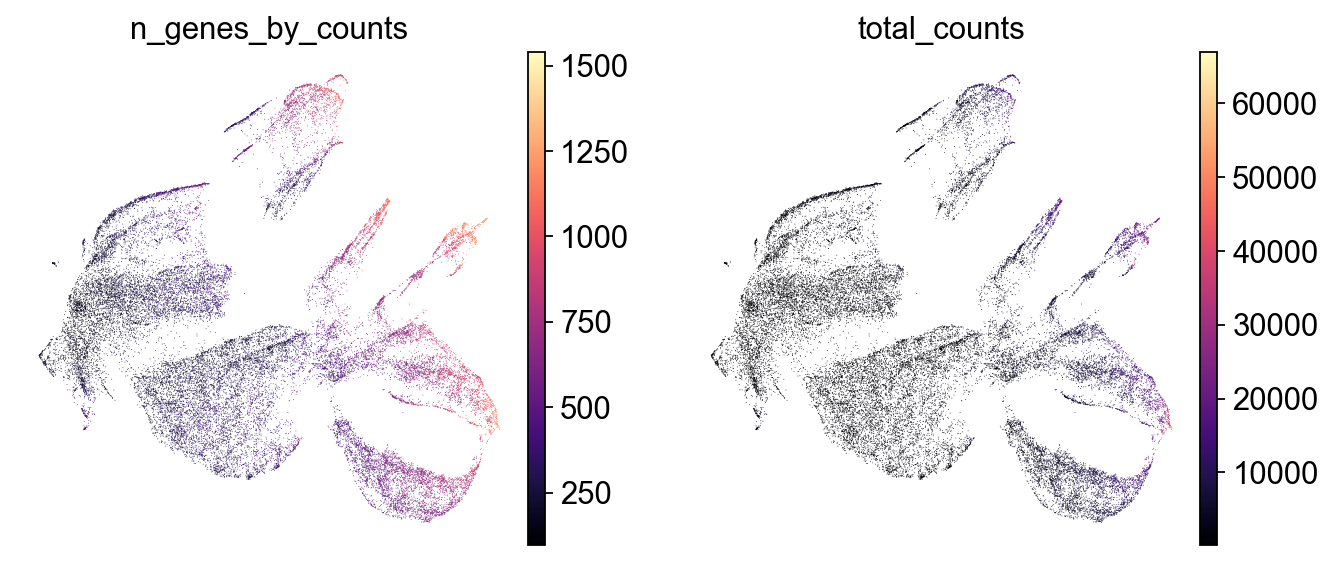

In [159]:
sc.pl.umap(adata_full, frameon = False, color = ['n_genes_by_counts', 'total_counts'], size = 0.6, legend_fontsize = 5, ncols = 3, color_map = "magma")